# 시계열 예측 전처리 + 모델링

### data import

In [1]:
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import models, layers
import seaborn as sns

filename = 'dataset/shampoo-three-year.csv'

/home/admin_user/anaconda3/envs/gsshop/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/admin_user/anaconda3/envs/gsshop/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
dataset = pd.read_csv(filename)

In [3]:
dataset = dataset.dropna()

In [4]:
dataset.shape

(36, 2)

### data preview

In [18]:
dataset.head(40)

,Month,Sales of shampoo over a three year period
0,1901-01-01,266.0
1,1901-02-01,145.9
2,1901-03-01,183.1
3,1901-04-01,119.3
4,1901-05-01,180.3
5,1901-06-01,168.5
6,1901-07-01,231.8
7,1901-08-01,224.5
8,1901-09-01,192.8
9,1901-10-01,122.9


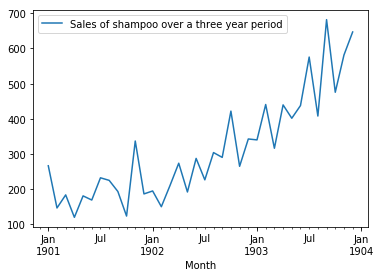

In [19]:
dataset['Month'] = pd.to_datetime(dataset['Month'])
dataset.index = dataset['Month']
dataset.set_index('Month', inplace=True)
dataset.plot()
plt.show()

## data preprocessing

#### make n-step to n-step forecast dataset

In [20]:
dataset.values

array([[266. ],
       [145.9],
       [183.1],
       [119.3],
       [180.3],
       [168.5],
       [231.8],
       [224.5],
       [192.8],
       [122.9],
       [336.5],
       [185.9],
       [194.3],
       [149.5],
       [210.1],
       [273.3],
       [191.4],
       [287. ],
       [226. ],
       [303.6],
       [289.9],
       [421.6],
       [264.5],
       [342.3],
       [339.7],
       [440.4],
       [315.9],
       [439.3],
       [401.3],
       [437.4],
       [575.5],
       [407.6],
       [682. ],
       [475.3],
       [581.3],
       [646.9]])

In [21]:
"""
x_step : n-lag (몇 개를 가지고 예측할지)
y_step : n-seq (몇 개를 예측할지)
"""
def make_timeseries_dataset_random_ordered(series, x_steps=1, y_steps=1, test_size=0.2):
    def split_dataset(timeseries_data):
        x_data = timeseries_data[:, :x_steps]
        y_data = timeseries_data[:, x_steps:]
        return train_test_split(x_data, y_data, test_size=test_size)
    
    result = None
    for i in range(len(series)):
        # next step index limit
        if i <= len(series) - x_steps - y_steps:
            row = np.array([])
            # make 1 row by defined timeseries steps
            for step in range(x_steps + y_steps):
                row = np.concatenate((row, series[i+step]))
            # append row to result np array
            if result is None:
                result = row
            else:
                result = np.vstack((result, row))
    return split_dataset(result)
        

In [22]:
x_train, x_test, y_train, y_test = make_timeseries_dataset_random_ordered(series=dataset.values, x_steps=3, y_steps=1, test_size=0.2)

In [23]:
print('training X data shape:', x_train.shape)
print('training Y data shape:', y_train.shape)
print('test X data shape:', x_test.shape)
print('test Y data shape:', y_test.shape)

training X data shape: (26, 3)
training Y data shape: (26, 1)
test X data shape: (7, 3)
test Y data shape: (7, 1)


# Modeling 1. Prophet

In [24]:
!pip install pystan fbprophet

Prophet follows the sklearn model API. 
We create an instance of the Prophet class and then call its fit and predict methods.

In [25]:
from fbprophet import Prophet

### banila prediction (monthly)

In [26]:
dataset = pd.read_csv(filename)
dataset.columns = ['ds', 'y']
dataset.head()

,ds,y
0,1901-01-01,266.0
1,1901-02-01,145.9
2,1901-03-01,183.1
3,1901-04-01,119.3
4,1901-05-01,180.3


In [27]:
# month data fit : mode parameter setting
m = Prophet(seasonality_mode='multiplicative', weekly_seasonality=False, daily_seasonality=False)
m.fit(dataset)

/home/admin_user/anaconda3/envs/gsshop/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [28]:
future_data = m.make_future_dataframe(periods=1, freq = 'm')

In [29]:
forecast_data = m.predict(future_data)

In [30]:
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
32,1903-09-01,581.871518,503.675971,662.984548
33,1903-10-01,491.845550,408.336951,576.841930
34,1903-11-01,540.990388,460.442058,617.070640
35,1903-12-01,569.817744,489.242209,651.151953
36,1903-12-31,500.759688,416.637110,581.458631


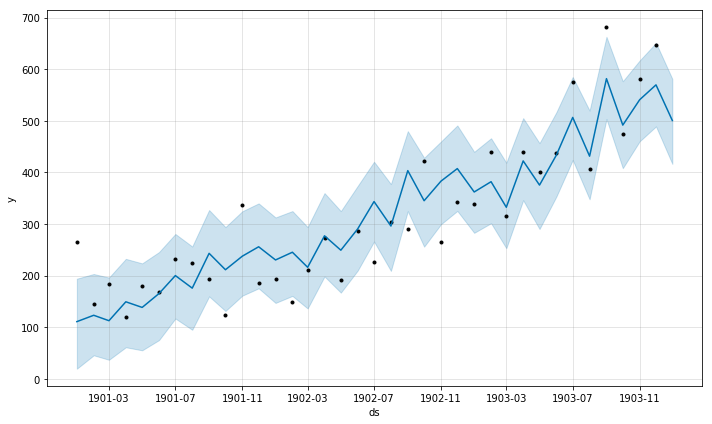

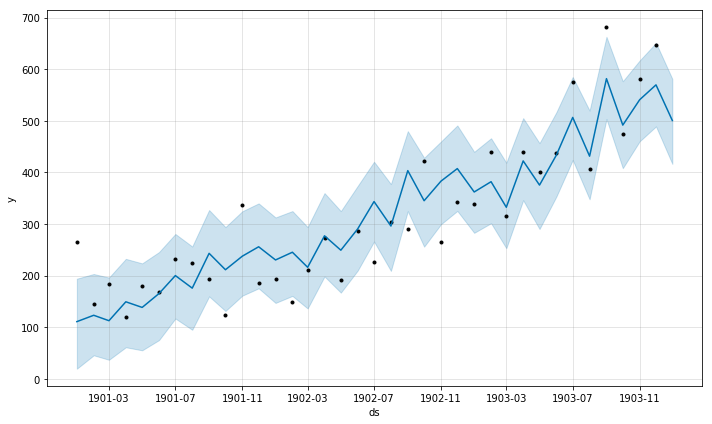

In [31]:
m.plot(forecast_data)

In [32]:
forecast_data.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,1901-01-01,117.291396,19.635497,194.105454,117.291396,117.291396,-0.054694,-0.054694,-0.054694,-0.054694,-0.054694,-0.054694,0.0,0.0,0.0,110.876249
1,1901-02-01,128.037159,45.642666,203.181290,128.037159,128.037159,-0.037636,-0.037636,-0.037636,-0.037636,-0.037636,-0.037636,0.0,0.0,0.0,123.218289
2,1901-03-01,137.743009,36.952110,196.281434,137.743009,137.743009,-0.181830,-0.181830,-0.181830,-0.181830,-0.181830,-0.181830,0.0,0.0,0.0,112.697259
3,1901-04-01,148.488772,61.223333,232.552494,148.488772,148.488772,0.005806,0.005806,0.005806,0.005806,0.005806,0.005806,0.0,0.0,0.0,149.350918
4,1901-05-01,158.887897,55.301146,223.813606,158.887897,158.887897,-0.128727,-0.128727,-0.128727,-0.128727,-0.128727,-0.128727,0.0,0.0,0.0,138.434781


### apply saturating forecasting

- logistic growth 형태(상한과 하한이 있는 모형)로 예측 모델을 만들어 주는것.
- 일반적인 시계열 예측 모델은 saturating point가 있기 때문.

In [33]:
df_saturating = dataset
df_saturating['cap'] = 400
df_saturating['floor'] = 300

# month data fit : mode parameter setting
m = Prophet(growth='logistic', seasonality_mode='multiplicative', weekly_seasonality=False, daily_seasonality=False)
m.fit(df_saturating)

/home/admin_user/anaconda3/envs/gsshop/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [34]:
future_data = m.make_future_dataframe(periods=1, freq = 'm')
future_data['cap'] = 400
future_data['floor'] = 300
forecast_data = m.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
32,1903-09-01,420.497187,268.055742,574.566346
33,1903-10-01,396.816812,248.914036,544.896743
34,1903-11-01,400.333321,249.242329,556.087571
35,1903-12-01,422.099080,269.621419,574.584471
36,1903-12-31,380.605378,235.735474,529.949251


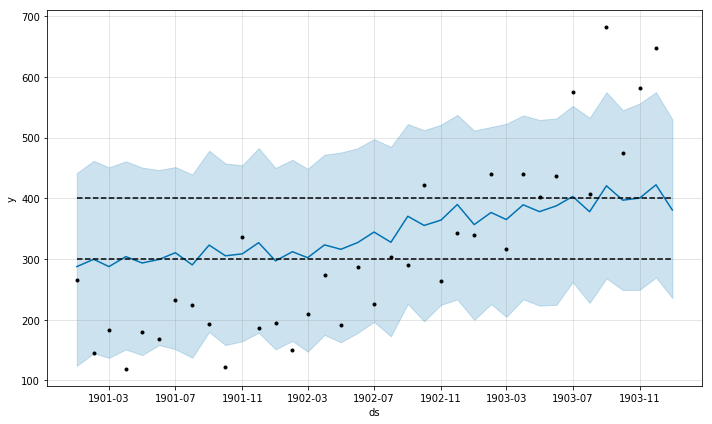

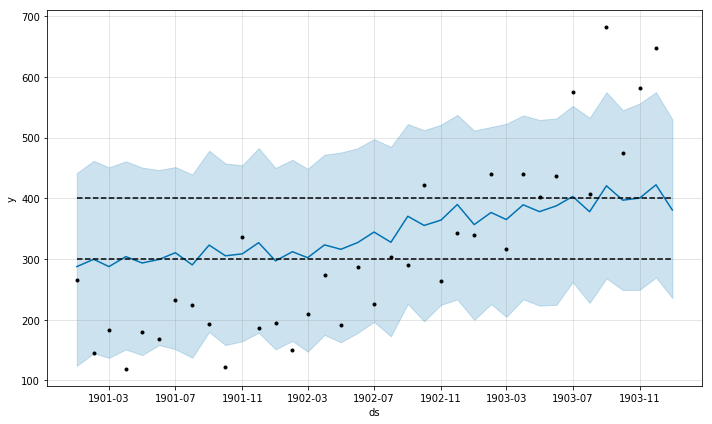

In [35]:
m.plot(forecast_data)

### outlier가 포함된 시계열 예측

In [36]:
dataset.loc[dataset['ds'] == '1902-07-01', 'y'] = 850
dataset.loc[dataset['ds'] == '1902-12-01', 'y'] = 10

In [37]:
# month data fit : mode parameter setting
m = Prophet(seasonality_mode='multiplicative', weekly_seasonality=False, daily_seasonality=False)
m.fit(dataset)

/home/admin_user/anaconda3/envs/gsshop/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [38]:
future_data = m.make_future_dataframe(periods=1, freq = 'm')
forecast_data = m.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
32,1903-09-01,548.703761,403.711937,697.432412
33,1903-10-01,469.533135,330.938568,613.416387
34,1903-11-01,523.177099,376.059272,662.304803
35,1903-12-01,415.586594,284.047661,551.806073
36,1903-12-31,502.178388,358.167302,642.274798


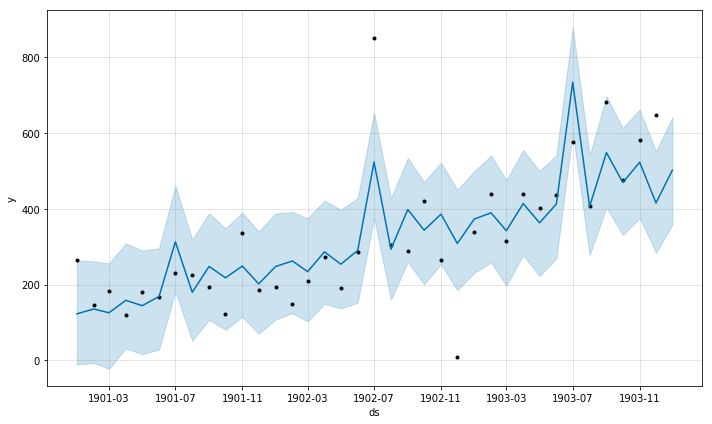

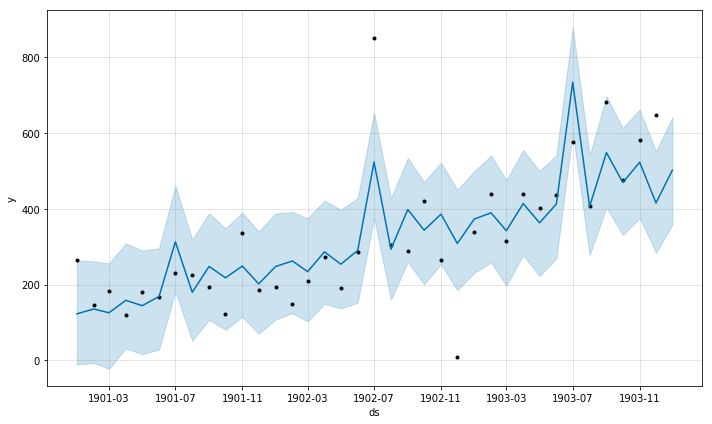

In [39]:
m.plot(forecast_data)

### rm outlier

In [40]:
dataset.loc[dataset['ds'] == '1902-07-01', 'y'] = None
dataset.loc[dataset['ds'] == '1902-12-01', 'y'] = None

In [41]:
# month data fit : mode parameter setting
m = Prophet(seasonality_mode='multiplicative', weekly_seasonality=False, daily_seasonality=False)
m.fit(dataset)

/home/admin_user/anaconda3/envs/gsshop/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [42]:
future_data = m.make_future_dataframe(periods=1, freq = 'm')
forecast_data = m.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
32,1903-09-01,575.752200,494.765027,650.683026
33,1903-10-01,488.268345,415.466835,565.511536
34,1903-11-01,535.208522,457.533264,608.438822
35,1903-12-01,602.970974,522.227912,684.585049
36,1903-12-31,484.517788,411.577392,561.738063


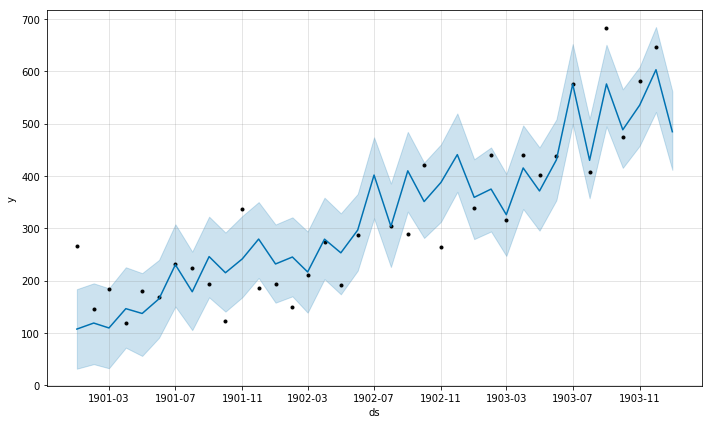

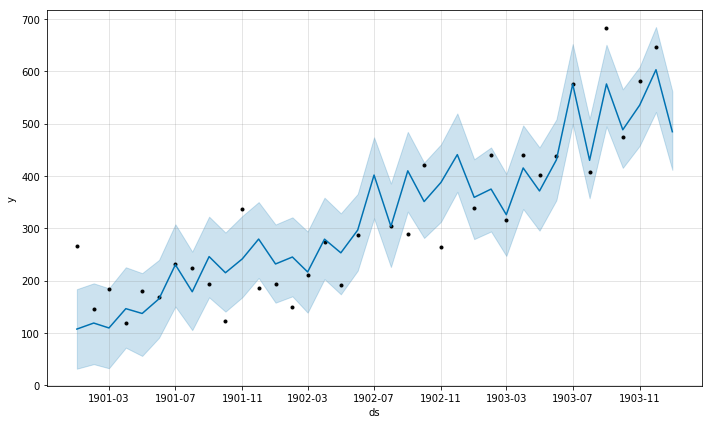

In [43]:
m.plot(forecast_data)

## Modeling 2. ARIMA(Autoregressive Integrated Moving Average)

- ARIMA는 Autoregressive Integrated Moving Average의 약자로, Autoregressive는 자기회귀 모형을 의미하고, Moving Average는 이동평균 모형을 의미한다.
- AR(Autoregression), 자기회귀 모형 : 이전의 자신의 관측값이 이후의 자신의 관측값에 영향을 준다는 아이디어의 모형이다. 큰 틀에서의 의미는 RNN과 완전히 동일하다. 다만, 선형적인 관계만을 정의하므로 정확하지는 않다.
- AR의 수식 : AR(1) -> Xt = theta * Xt-1 + et

- MA(Moving Average), 이동평균 모형 : 현재의 관측값이 이전의 관측 오차항에 영향을 받는다는 아이디어의 모형이다. 
- MA(1) -> Xt = et - B1 * et-1

- 이를 합한 ARMA 모형은 다음과 같다. 
- Xt=ϕXt−1+Wt+θWt−1
- 즉 정상성이 보장된다는 조건 하에 p차까지 자기회귀를 하고, 남은 잔차의 상관관계를 이용하여 오차항을 만들어내는 모형이다.
- ARIMA에서 I는 Integrated를 의미하는데, ARMA에서 시계열의 비정상성을 설명하기 위해 차분방정식의 개념을 도입하여 보정한 것을 의미하는 용어이다.

--------

- ARIMA의 하이퍼 파라미터는 3가지이다.
- (p, d , q)의 세 가지로, p와 q는 각각 AR, MA의 lag 개수를 의미하며 d는 차분의 횟수를 의미한다.

<img src="images/ARIMA.png">

### hyper parameter를 선정하는 방법
- ACF(Autocorrelation function) : Lag에 따른 관측치들 사이의 관련성을 측정하는 함수
- PACF(Partial autocorrelation function) : k 이외의 모든 다른 시점 관측치의 영향력을 배제하고 yt와 yt-k 두 관측치의 관련성을 측정하는 함수
- 두 그래프 중, 감소폭이나 증가폭이 완만한 그래프가 더 강한 영향을 미치는 것이라고 볼 수 있다.

- 시계열 데이터가 AR의 특성을 띄는 경우, ACF는 천천히 감소하고 PACF는 처음 시차를 제외하고 급격히 감소한다.
- 반대로, MA의 특성을 띄는 경우 ACF는 급격히 감소하고 PACF는 천천히 감소한다.
- 급격히 감소하는 시차를 각 AR과 MA 모형의 모수(p, q)로 사용할 수 있다. 
- 또한 데이터를 차분하여 ACF 및 PACF 계산함으로써 적절한 차분횟수까지 구할 수 있다

In [44]:
dataset = pd.read_csv(filename)
dataset.columns = ['Month', 'sale']
dataset['Month'] = pd.to_datetime(dataset['Month'])
dataset.index = dataset['Month']
dataset.set_index('Month', inplace=True)
series = dataset

/home/admin_user/anaconda3/envs/gsshop/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


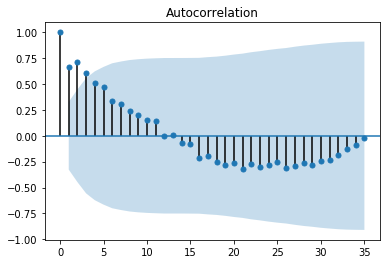

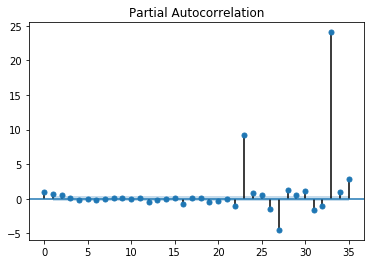

In [45]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(series)
plot_pacf(series)
plt.show()

#### ARIMA 모델링

In [46]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(series, order=(4,1,0)) # P>|z| -> 학습 계수에 대한 p-value 값으로, (a,b,c) 일때 가장 적절한 조합을 찾아야 한다.
model_fit = model.fit(trend='c',full_output=True, disp=True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.sale   No. Observations:                   35
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -196.393
Method:                       css-mle   S.D. of innovations             64.746
Date:                Wed, 29 Aug 2018   AIC                            404.787
Time:                        10:13:32   BIC                            414.119
Sample:                    02-01-1901   HQIC                           408.008
                         - 12-01-1903                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           12.1964      3.217      3.791      0.001       5.891      18.502
ar.L1.D.sale    -1.1456      0.176     -6.504      0.000      -1.491      -0.800
ar.L2.D.sale    -0.6921      0.264     -2.62

/home/admin_user/anaconda3/envs/gsshop/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/admin_user/anaconda3/envs/gsshop/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/admin_user/anaconda3/envs/gsshop/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/admin_user/anaconda3/envs/gsshop/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimension

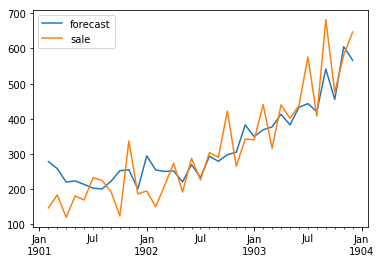

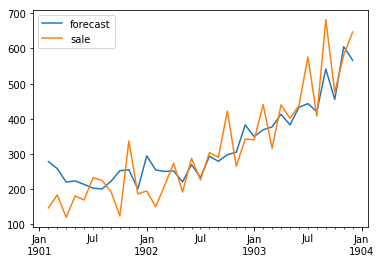

In [47]:
model_fit.plot_predict()

In [48]:
fore = model_fit.forecast(steps=3)
print(fore[0]) # 예측값

[562.5949631  664.01604686 591.62440332]


## Modeling 3. LSTM
### 3-1) multi-to-one step

In [5]:
import os
import math
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#### preprocessing for time-step forecasting

In [6]:
dataset = pd.read_csv(filename)
dataset['Month'] = pd.to_datetime(dataset['Month'])
dataset.index = dataset['Month']
dataset.set_index('Month', inplace=True)
origin_series = dataset.values

"""
시계열 예측시에는 t, t-1 의 차이값을 value로 활용
"""
def difference(series, interval=1):
    diff = list()
    for i in range(interval, len(series)):
        value = series[i] - series[i - interval]
        diff.append(value)
    return np.array(diff)

"""
x_step : n-lag (몇 개를 가지고 예측할지)
y_step : n-seq (몇 개를 예측할지)
"""
def make_timeseries_dataset_ordered(series, x_steps=1, y_steps=1, test_size=0.2):
    def split_dataset(timeseries_data):
        x_data = timeseries_data[:, :x_steps]
        y_data = timeseries_data[:, x_steps:]
        train_len = int(x_data.shape[0] * (1 - test_size))
        x_train = x_data[:train_len, :]
        x_test = x_data[train_len:, :]
        y_train =  y_data[:train_len, :]
        y_test = y_data[train_len:, :]
        return (x_train, x_test, y_train, y_test)
    
    result = None
    for i in range(len(series)):
        # next step index limit
        if i <= len(series) - x_steps - y_steps:
            row = np.array([])
            # make 1 row by defined timeseries steps
            for step in range(x_steps + y_steps):
                row = np.concatenate((row, series[i+step]))
            # append row to result np array
            if result is None:
                result = row
            else:
                result = np.vstack((result, row))
    return split_dataset(result)

"""
split origin dataset
"""
# def split_dataset():
    

# split origin dataset
origin_x_train, origin_x_test, origin_y_train, origin_y_test = make_timeseries_dataset_ordered(series=origin_series, x_steps=1, y_steps=1, test_size=0.4)
# transform original value to diff value
diff_series = difference(origin_series, 1)
# min-max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_series = scaler.fit_transform(diff_series)
# split and make timeseries
x_train, x_test, y_train, y_test = make_timeseries_dataset_ordered(series=scaled_series, x_steps=4, y_steps=1, test_size=0.4)

- print shape

In [7]:
print('training X data shape:', origin_x_train.shape)
print('training Y data shape:', origin_y_train.shape)
print('test X data shape:', origin_x_test.shape)
print('test Y data shape:', origin_y_test.shape)

training X data shape: (21, 1)
training Y data shape: (21, 1)
test X data shape: (14, 1)
test Y data shape: (14, 1)


In [8]:
print('training X data shape:', x_train.shape)
print('training Y data shape:', y_train.shape)
print('test X data shape:', x_test.shape)
print('test Y data shape:', y_test.shape)

training X data shape: (18, 4)
training Y data shape: (18, 1)
test X data shape: (13, 4)
test Y data shape: (13, 1)


In [9]:
# data reshape : for trim batch size (train, predict in Neural Networks)
x_train = x_train[:16, :]
y_train = y_train[:16, :]
x_test = x_test[:12, :]
y_test = y_test[:12, :]

In [10]:
print('training X data shape:', x_train.shape)
print('training Y data shape:', y_train.shape)
print('test X data shape:', x_test.shape)
print('test Y data shape:', y_test.shape)

training X data shape: (16, 4)
training Y data shape: (16, 1)
test X data shape: (12, 4)
test Y data shape: (12, 1)


- change shape for (LSTM or RNN)

In [11]:
"""
(size, timestep, feature) 의 형식으로 맞춰줘야 함
size : batch를 돌 데이터 사이즈
timestep : input의 time 개수 (X_t1, X_t2...)
feature : feature의 개수 (X = x1, x2 ...) [ex: x1 - 키, x2 - 몸무게 ...]
"""

time_step = 4
feature_num = 1

x_train_series = x_train.reshape(x_train.shape[0], time_step, feature_num)
x_test_series = x_test.reshape(x_test.shape[0], time_step, feature_num)

#### LSTM modeling code

In [12]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

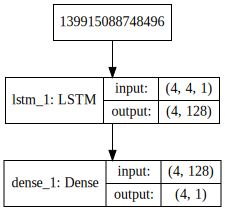

In [13]:
model = Sequential()
model.add(LSTM(128, batch_input_shape=(4, 4, 1), # batch_input_shape = (배치사이즈, 타임스텝, 속성)
               return_sequences=False, 
               stateful=True))
model.add(Dense(1)) # output = 1
model.compile(loss='mean_squared_error', optimizer='adam')

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

- return_sequences : many-to-many 문제나 lstm가 멀티 레이어인 경우 사용함. 각 time마다 y값을 출력 하느냐 마느냐의 결정.
- stateful : 상태유지모드 결정. 

#### stateful True

In [14]:
num_epochs = 1500
batch_size=4

# simple lstm network learning
model = Sequential()
model.add(LSTM(3, batch_input_shape=(batch_size, time_step, feature_num), # batch_input_shape = (배치사이즈, 타임스텝, 속성)
               return_sequences=False, 
               stateful=True))
model.add(Dense(1)) # output = 1
model.compile(loss='mean_squared_error', optimizer='adam')

for epoch_idx in range(num_epochs):
    print ('epochs : ' + str(epoch_idx) )
    model.fit(x_train_series, y_train, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model.reset_states()

epochs : 0
Epoch 1/1
16/16 [==============================] - 1s 32ms/step - loss: 0.0638
epochs : 1
Epoch 1/1
16/16 [==============================] - 0s 821us/step - loss: 0.0574
epochs : 2
Epoch 1/1
16/16 [==============================] - 0s 591us/step - loss: 0.0520
epochs : 3
Epoch 1/1
16/16 [==============================] - 0s 804us/step - loss: 0.0477
epochs : 4
Epoch 1/1
16/16 [==============================] - 0s 713us/step - loss: 0.0444
epochs : 5
Epoch 1/1
16/16 [==============================] - 0s 839us/step - loss: 0.0420
epochs : 6
Epoch 1/1
16/16 [==============================] - 0s 643us/step - loss: 0.0403
epochs : 7
Epoch 1/1
16/16 [==============================] - 0s 655us/step - loss: 0.0393
epochs : 8
Epoch 1/1
16/16 [==============================] - 0s 536us/step - loss: 0.0387
epochs : 9
Epoch 1/1
16/16 [==============================] - 0s 859us/step - loss: 0.0385
epochs : 10
Epoch 1/1
16/16 [==============================] - 0s 658us/step - loss: 0.0383

16/16 [==============================] - 0s 849us/step - loss: 0.0331
epochs : 90
Epoch 1/1
16/16 [==============================] - 0s 739us/step - loss: 0.0331
epochs : 91
Epoch 1/1
16/16 [==============================] - 0s 997us/step - loss: 0.0330
epochs : 92
Epoch 1/1
16/16 [==============================] - 0s 727us/step - loss: 0.0330
epochs : 93
Epoch 1/1
16/16 [==============================] - 0s 841us/step - loss: 0.0329
epochs : 94
Epoch 1/1
16/16 [==============================] - 0s 711us/step - loss: 0.0329
epochs : 95
Epoch 1/1
16/16 [==============================] - 0s 799us/step - loss: 0.0328
epochs : 96
Epoch 1/1
16/16 [==============================] - 0s 673us/step - loss: 0.0327
epochs : 97
Epoch 1/1
16/16 [==============================] - 0s 709us/step - loss: 0.0327
epochs : 98
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0326
epochs : 99
Epoch 1/1
16/16 [==============================] - 0s 1000us/step - loss: 0.0326
epochs : 10

16/16 [==============================] - 0s 632us/step - loss: 0.0274
epochs : 178
Epoch 1/1
16/16 [==============================] - 0s 538us/step - loss: 0.0273
epochs : 179
Epoch 1/1
16/16 [==============================] - 0s 554us/step - loss: 0.0272
epochs : 180
Epoch 1/1
16/16 [==============================] - 0s 639us/step - loss: 0.0271
epochs : 181
Epoch 1/1
16/16 [==============================] - 0s 716us/step - loss: 0.0270
epochs : 182
Epoch 1/1
16/16 [==============================] - 0s 702us/step - loss: 0.0269
epochs : 183
Epoch 1/1
16/16 [==============================] - 0s 740us/step - loss: 0.0268
epochs : 184
Epoch 1/1
16/16 [==============================] - 0s 678us/step - loss: 0.0268
epochs : 185
Epoch 1/1
16/16 [==============================] - 0s 620us/step - loss: 0.0267
epochs : 186
Epoch 1/1
16/16 [==============================] - 0s 728us/step - loss: 0.0266
epochs : 187
Epoch 1/1
16/16 [==============================] - 0s 606us/step - loss: 0.0265


16/16 [==============================] - 0s 597us/step - loss: 0.0202
epochs : 266
Epoch 1/1
16/16 [==============================] - 0s 595us/step - loss: 0.0202
epochs : 267
Epoch 1/1
16/16 [==============================] - 0s 548us/step - loss: 0.0201
epochs : 268
Epoch 1/1
16/16 [==============================] - 0s 627us/step - loss: 0.0200
epochs : 269
Epoch 1/1
16/16 [==============================] - 0s 628us/step - loss: 0.0200
epochs : 270
Epoch 1/1
16/16 [==============================] - 0s 644us/step - loss: 0.0199
epochs : 271
Epoch 1/1
16/16 [==============================] - 0s 574us/step - loss: 0.0198
epochs : 272
Epoch 1/1
16/16 [==============================] - 0s 505us/step - loss: 0.0198
epochs : 273
Epoch 1/1
16/16 [==============================] - 0s 609us/step - loss: 0.0197
epochs : 274
Epoch 1/1
16/16 [==============================] - 0s 468us/step - loss: 0.0196
epochs : 275
Epoch 1/1
16/16 [==============================] - 0s 838us/step - loss: 0.0196


16/16 [==============================] - 0s 656us/step - loss: 0.0161
epochs : 354
Epoch 1/1
16/16 [==============================] - 0s 626us/step - loss: 0.0161
epochs : 355
Epoch 1/1
16/16 [==============================] - 0s 466us/step - loss: 0.0161
epochs : 356
Epoch 1/1
16/16 [==============================] - 0s 594us/step - loss: 0.0160
epochs : 357
Epoch 1/1
16/16 [==============================] - 0s 622us/step - loss: 0.0160
epochs : 358
Epoch 1/1
16/16 [==============================] - 0s 635us/step - loss: 0.0160
epochs : 359
Epoch 1/1
16/16 [==============================] - 0s 497us/step - loss: 0.0159
epochs : 360
Epoch 1/1
16/16 [==============================] - 0s 626us/step - loss: 0.0159
epochs : 361
Epoch 1/1
16/16 [==============================] - 0s 492us/step - loss: 0.0159
epochs : 362
Epoch 1/1
16/16 [==============================] - 0s 738us/step - loss: 0.0159
epochs : 363
Epoch 1/1
16/16 [==============================] - 0s 960us/step - loss: 0.0158


16/16 [==============================] - 0s 623us/step - loss: 0.0146
epochs : 442
Epoch 1/1
16/16 [==============================] - 0s 753us/step - loss: 0.0146
epochs : 443
Epoch 1/1
16/16 [==============================] - 0s 502us/step - loss: 0.0146
epochs : 444
Epoch 1/1
16/16 [==============================] - 0s 669us/step - loss: 0.0146
epochs : 445
Epoch 1/1
16/16 [==============================] - 0s 663us/step - loss: 0.0146
epochs : 446
Epoch 1/1
16/16 [==============================] - 0s 664us/step - loss: 0.0145
epochs : 447
Epoch 1/1
16/16 [==============================] - 0s 641us/step - loss: 0.0145
epochs : 448
Epoch 1/1
16/16 [==============================] - 0s 694us/step - loss: 0.0145
epochs : 449
Epoch 1/1
16/16 [==============================] - 0s 692us/step - loss: 0.0145
epochs : 450
Epoch 1/1
16/16 [==============================] - 0s 636us/step - loss: 0.0145
epochs : 451
Epoch 1/1
16/16 [==============================] - 0s 645us/step - loss: 0.0145


16/16 [==============================] - 0s 511us/step - loss: 0.0140
epochs : 530
Epoch 1/1
16/16 [==============================] - 0s 542us/step - loss: 0.0140
epochs : 531
Epoch 1/1
16/16 [==============================] - 0s 470us/step - loss: 0.0140
epochs : 532
Epoch 1/1
16/16 [==============================] - 0s 430us/step - loss: 0.0140
epochs : 533
Epoch 1/1
16/16 [==============================] - 0s 540us/step - loss: 0.0140
epochs : 534
Epoch 1/1
16/16 [==============================] - 0s 2ms/step - loss: 0.0140
epochs : 535
Epoch 1/1
16/16 [==============================] - 0s 731us/step - loss: 0.0140
epochs : 536
Epoch 1/1
16/16 [==============================] - 0s 958us/step - loss: 0.0140
epochs : 537
Epoch 1/1
16/16 [==============================] - 0s 666us/step - loss: 0.0140
epochs : 538
Epoch 1/1
16/16 [==============================] - 0s 666us/step - loss: 0.0140
epochs : 539
Epoch 1/1
16/16 [==============================] - 0s 708us/step - loss: 0.0140
ep

16/16 [==============================] - 0s 581us/step - loss: 0.0138
epochs : 618
Epoch 1/1
16/16 [==============================] - 0s 644us/step - loss: 0.0138
epochs : 619
Epoch 1/1
16/16 [==============================] - 0s 579us/step - loss: 0.0137
epochs : 620
Epoch 1/1
16/16 [==============================] - 0s 567us/step - loss: 0.0137
epochs : 621
Epoch 1/1
16/16 [==============================] - 0s 662us/step - loss: 0.0137
epochs : 622
Epoch 1/1
16/16 [==============================] - 0s 704us/step - loss: 0.0137
epochs : 623
Epoch 1/1
16/16 [==============================] - 0s 616us/step - loss: 0.0137
epochs : 624
Epoch 1/1
16/16 [==============================] - 0s 606us/step - loss: 0.0137
epochs : 625
Epoch 1/1
16/16 [==============================] - 0s 1ms/step - loss: 0.0137
epochs : 626
Epoch 1/1
16/16 [==============================] - 0s 629us/step - loss: 0.0137
epochs : 627
Epoch 1/1
16/16 [==============================] - 0s 591us/step - loss: 0.0137
ep

16/16 [==============================] - 0s 684us/step - loss: 0.0136
epochs : 706
Epoch 1/1
16/16 [==============================] - 0s 939us/step - loss: 0.0136
epochs : 707
Epoch 1/1
16/16 [==============================] - 0s 768us/step - loss: 0.0135
epochs : 708
Epoch 1/1
16/16 [==============================] - 0s 639us/step - loss: 0.0135
epochs : 709
Epoch 1/1
16/16 [==============================] - 0s 848us/step - loss: 0.0135
epochs : 710
Epoch 1/1
16/16 [==============================] - 0s 920us/step - loss: 0.0135
epochs : 711
Epoch 1/1
16/16 [==============================] - 0s 633us/step - loss: 0.0135
epochs : 712
Epoch 1/1
16/16 [==============================] - 0s 554us/step - loss: 0.0135
epochs : 713
Epoch 1/1
16/16 [==============================] - 0s 626us/step - loss: 0.0135
epochs : 714
Epoch 1/1
16/16 [==============================] - 0s 577us/step - loss: 0.0135
epochs : 715
Epoch 1/1
16/16 [==============================] - 0s 586us/step - loss: 0.0135


16/16 [==============================] - 0s 634us/step - loss: 0.0134
epochs : 794
Epoch 1/1
16/16 [==============================] - 0s 781us/step - loss: 0.0134
epochs : 795
Epoch 1/1
16/16 [==============================] - 0s 493us/step - loss: 0.0134
epochs : 796
Epoch 1/1
16/16 [==============================] - 0s 757us/step - loss: 0.0134
epochs : 797
Epoch 1/1
16/16 [==============================] - 0s 572us/step - loss: 0.0134
epochs : 798
Epoch 1/1
16/16 [==============================] - 0s 491us/step - loss: 0.0134
epochs : 799
Epoch 1/1
16/16 [==============================] - 0s 778us/step - loss: 0.0134
epochs : 800
Epoch 1/1
16/16 [==============================] - 0s 878us/step - loss: 0.0134
epochs : 801
Epoch 1/1
16/16 [==============================] - 0s 638us/step - loss: 0.0134
epochs : 802
Epoch 1/1
16/16 [==============================] - 0s 531us/step - loss: 0.0134
epochs : 803
Epoch 1/1
16/16 [==============================] - 0s 998us/step - loss: 0.0134


16/16 [==============================] - 0s 1ms/step - loss: 0.0132
epochs : 882
Epoch 1/1
16/16 [==============================] - 0s 613us/step - loss: 0.0132
epochs : 883
Epoch 1/1
16/16 [==============================] - 0s 616us/step - loss: 0.0132
epochs : 884
Epoch 1/1
16/16 [==============================] - 0s 565us/step - loss: 0.0132
epochs : 885
Epoch 1/1
16/16 [==============================] - 0s 778us/step - loss: 0.0132
epochs : 886
Epoch 1/1
16/16 [==============================] - 0s 633us/step - loss: 0.0132
epochs : 887
Epoch 1/1
16/16 [==============================] - 0s 746us/step - loss: 0.0132
epochs : 888
Epoch 1/1
16/16 [==============================] - 0s 607us/step - loss: 0.0132
epochs : 889
Epoch 1/1
16/16 [==============================] - 0s 600us/step - loss: 0.0132
epochs : 890
Epoch 1/1
16/16 [==============================] - 0s 598us/step - loss: 0.0132
epochs : 891
Epoch 1/1
16/16 [==============================] - 0s 575us/step - loss: 0.0132
ep

16/16 [==============================] - 0s 466us/step - loss: 0.0130
epochs : 970
Epoch 1/1
16/16 [==============================] - 0s 702us/step - loss: 0.0130
epochs : 971
Epoch 1/1
16/16 [==============================] - 0s 732us/step - loss: 0.0130
epochs : 972
Epoch 1/1
16/16 [==============================] - 0s 618us/step - loss: 0.0130
epochs : 973
Epoch 1/1
16/16 [==============================] - 0s 582us/step - loss: 0.0130
epochs : 974
Epoch 1/1
16/16 [==============================] - 0s 759us/step - loss: 0.0130
epochs : 975
Epoch 1/1
16/16 [==============================] - 0s 554us/step - loss: 0.0130
epochs : 976
Epoch 1/1
16/16 [==============================] - 0s 740us/step - loss: 0.0130
epochs : 977
Epoch 1/1
16/16 [==============================] - 0s 681us/step - loss: 0.0130
epochs : 978
Epoch 1/1
16/16 [==============================] - 0s 568us/step - loss: 0.0130
epochs : 979
Epoch 1/1
16/16 [==============================] - 0s 792us/step - loss: 0.0130


16/16 [==============================] - 0s 770us/step - loss: 0.0129
epochs : 1057
Epoch 1/1
16/16 [==============================] - 0s 615us/step - loss: 0.0129
epochs : 1058
Epoch 1/1
16/16 [==============================] - 0s 477us/step - loss: 0.0129
epochs : 1059
Epoch 1/1
16/16 [==============================] - 0s 602us/step - loss: 0.0129
epochs : 1060
Epoch 1/1
16/16 [==============================] - 0s 657us/step - loss: 0.0129
epochs : 1061
Epoch 1/1
16/16 [==============================] - 0s 593us/step - loss: 0.0129
epochs : 1062
Epoch 1/1
16/16 [==============================] - 0s 609us/step - loss: 0.0129
epochs : 1063
Epoch 1/1
16/16 [==============================] - 0s 814us/step - loss: 0.0129
epochs : 1064
Epoch 1/1
16/16 [==============================] - 0s 662us/step - loss: 0.0129
epochs : 1065
Epoch 1/1
16/16 [==============================] - 0s 489us/step - loss: 0.0129
epochs : 1066
Epoch 1/1
16/16 [==============================] - 0s 672us/step - los

16/16 [==============================] - 0s 1ms/step - loss: 0.0127
epochs : 1144
Epoch 1/1
16/16 [==============================] - 0s 598us/step - loss: 0.0127
epochs : 1145
Epoch 1/1
16/16 [==============================] - 0s 543us/step - loss: 0.0127
epochs : 1146
Epoch 1/1
16/16 [==============================] - 0s 726us/step - loss: 0.0127
epochs : 1147
Epoch 1/1
16/16 [==============================] - 0s 626us/step - loss: 0.0127
epochs : 1148
Epoch 1/1
16/16 [==============================] - 0s 650us/step - loss: 0.0127
epochs : 1149
Epoch 1/1
16/16 [==============================] - 0s 610us/step - loss: 0.0127
epochs : 1150
Epoch 1/1
16/16 [==============================] - 0s 531us/step - loss: 0.0127
epochs : 1151
Epoch 1/1
16/16 [==============================] - 0s 496us/step - loss: 0.0127
epochs : 1152
Epoch 1/1
16/16 [==============================] - 0s 411us/step - loss: 0.0127
epochs : 1153
Epoch 1/1
16/16 [==============================] - 0s 548us/step - loss:

16/16 [==============================] - 0s 634us/step - loss: 0.0127
epochs : 1231
Epoch 1/1
16/16 [==============================] - 0s 658us/step - loss: 0.0127
epochs : 1232
Epoch 1/1
16/16 [==============================] - 0s 814us/step - loss: 0.0127
epochs : 1233
Epoch 1/1
16/16 [==============================] - 0s 563us/step - loss: 0.0127
epochs : 1234
Epoch 1/1
16/16 [==============================] - 0s 633us/step - loss: 0.0127
epochs : 1235
Epoch 1/1
16/16 [==============================] - 0s 502us/step - loss: 0.0127
epochs : 1236
Epoch 1/1
16/16 [==============================] - 0s 566us/step - loss: 0.0127
epochs : 1237
Epoch 1/1
16/16 [==============================] - 0s 632us/step - loss: 0.0127
epochs : 1238
Epoch 1/1
16/16 [==============================] - 0s 830us/step - loss: 0.0127
epochs : 1239
Epoch 1/1
16/16 [==============================] - 0s 570us/step - loss: 0.0127
epochs : 1240
Epoch 1/1
16/16 [==============================] - 0s 725us/step - los

16/16 [==============================] - 0s 696us/step - loss: 0.0128
epochs : 1318
Epoch 1/1
16/16 [==============================] - 0s 649us/step - loss: 0.0128
epochs : 1319
Epoch 1/1
16/16 [==============================] - 0s 539us/step - loss: 0.0128
epochs : 1320
Epoch 1/1
16/16 [==============================] - 0s 525us/step - loss: 0.0128
epochs : 1321
Epoch 1/1
16/16 [==============================] - 0s 635us/step - loss: 0.0128
epochs : 1322
Epoch 1/1
16/16 [==============================] - 0s 499us/step - loss: 0.0128
epochs : 1323
Epoch 1/1
16/16 [==============================] - 0s 628us/step - loss: 0.0128
epochs : 1324
Epoch 1/1
16/16 [==============================] - 0s 584us/step - loss: 0.0128
epochs : 1325
Epoch 1/1
16/16 [==============================] - 0s 775us/step - loss: 0.0128
epochs : 1326
Epoch 1/1
16/16 [==============================] - 0s 707us/step - loss: 0.0128
epochs : 1327
Epoch 1/1
16/16 [==============================] - 0s 622us/step - los

16/16 [==============================] - 0s 655us/step - loss: 0.0129
epochs : 1405
Epoch 1/1
16/16 [==============================] - 0s 684us/step - loss: 0.0129
epochs : 1406
Epoch 1/1
16/16 [==============================] - 0s 492us/step - loss: 0.0129
epochs : 1407
Epoch 1/1
16/16 [==============================] - 0s 499us/step - loss: 0.0129
epochs : 1408
Epoch 1/1
16/16 [==============================] - 0s 666us/step - loss: 0.0129
epochs : 1409
Epoch 1/1
16/16 [==============================] - 0s 499us/step - loss: 0.0129
epochs : 1410
Epoch 1/1
16/16 [==============================] - 0s 548us/step - loss: 0.0129
epochs : 1411
Epoch 1/1
16/16 [==============================] - 0s 627us/step - loss: 0.0129
epochs : 1412
Epoch 1/1
16/16 [==============================] - 0s 583us/step - loss: 0.0129
epochs : 1413
Epoch 1/1
16/16 [==============================] - 0s 531us/step - loss: 0.0129
epochs : 1414
Epoch 1/1
16/16 [==============================] - 0s 537us/step - los

16/16 [==============================] - 0s 588us/step - loss: 0.0129
epochs : 1492
Epoch 1/1
16/16 [==============================] - 0s 546us/step - loss: 0.0129
epochs : 1493
Epoch 1/1
16/16 [==============================] - 0s 492us/step - loss: 0.0129
epochs : 1494
Epoch 1/1
16/16 [==============================] - 0s 534us/step - loss: 0.0129
epochs : 1495
Epoch 1/1
16/16 [==============================] - 0s 992us/step - loss: 0.0129
epochs : 1496
Epoch 1/1
16/16 [==============================] - 0s 696us/step - loss: 0.0129
epochs : 1497
Epoch 1/1
16/16 [==============================] - 0s 538us/step - loss: 0.0129
epochs : 1498
Epoch 1/1
16/16 [==============================] - 0s 647us/step - loss: 0.0129
epochs : 1499
Epoch 1/1
16/16 [==============================] - 0s 682us/step - loss: 0.0129


In [15]:
def show_train_fit():
    output = model.predict(x_train_series, batch_size=batch_size)
    predictions = list()
    for i in range(len(output)):
        yhat = output[i,0]
        yhat = scaler.inverse_transform(yhat)
        yhat = yhat + origin_x_train[i+1]
        predictions.append(yhat)
    model.reset_states()
    return predictions

(16, 1)
(21, 1)


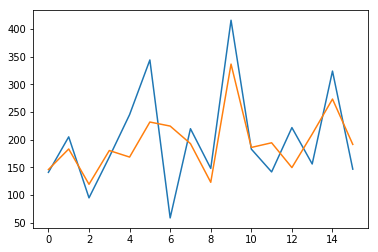

In [18]:
predictions = show_train_fit()
predictions = np.array(predictions)
predictions = predictions.reshape(predictions.shape[0], 1)

plt.plot(predictions) # blue line
plt.plot(origin_y_train[:predictions.shape[0]]) # yellow line
plt.show()

In [20]:
def show_test_fit():
    output = model.predict(x_test_series, batch_size=batch_size)
    predictions = list()
    for i in range(len(output)):
        yhat = output[i,0]
        yhat = scaler.inverse_transform(yhat)
        yhat = yhat + origin_x_test[i+1]
        predictions.append(yhat)
    model.reset_states()
    return predictions

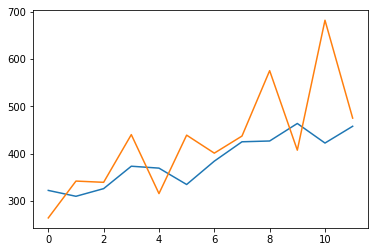

In [21]:
predictions = show_test_fit()
predictions = np.array(predictions)
predictions = predictions.reshape(predictions.shape[0], 1)

plt.plot(predictions) # blue line
plt.plot(origin_y_test[:predictions.shape[0]]) # yellow line
plt.show()

#### stateful False

In [22]:
num_epochs = 1500
batch_size=4

# simple lstm network learning
model = Sequential()
model.add(LSTM(3, batch_input_shape=(batch_size, time_step, feature_num), # batch_input_shape = (배치사이즈, 타임스텝, 속성)
               return_sequences=False, 
               stateful=False))
model.add(Dense(1)) # output = 1
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train_series, y_train, epochs=num_epochs, batch_size=batch_size, verbose=1, shuffle=False)

Epoch 1/1500
16/16 [==============================] - 1s 33ms/step - loss: 0.2693
Epoch 2/1500
16/16 [==============================] - 0s 495us/step - loss: 0.2568
Epoch 3/1500
16/16 [==============================] - 0s 579us/step - loss: 0.2447
Epoch 4/1500
16/16 [==============================] - 0s 986us/step - loss: 0.2331
Epoch 5/1500
16/16 [==============================] - 0s 586us/step - loss: 0.2218
Epoch 6/1500
16/16 [==============================] - 0s 892us/step - loss: 0.2110
Epoch 7/1500
16/16 [==============================] - 0s 592us/step - loss: 0.2007
Epoch 8/1500
16/16 [==============================] - 0s 868us/step - loss: 0.1908
Epoch 9/1500
16/16 [==============================] - 0s 504us/step - loss: 0.1812
Epoch 10/1500
16/16 [==============================] - 0s 705us/step - loss: 0.1722
Epoch 11/1500
16/16 [==============================] - 0s 850us/step - loss: 0.1635
Epoch 12/1500
16/16 [==============================] - 0s 735us/step - loss: 0.1552
Ep

16/16 [==============================] - 0s 675us/step - loss: 0.0332
Epoch 99/1500
16/16 [==============================] - 0s 711us/step - loss: 0.0332
Epoch 100/1500
16/16 [==============================] - 0s 593us/step - loss: 0.0332
Epoch 101/1500
16/16 [==============================] - 0s 613us/step - loss: 0.0331
Epoch 102/1500
16/16 [==============================] - 0s 692us/step - loss: 0.0331
Epoch 103/1500
16/16 [==============================] - 0s 699us/step - loss: 0.0331
Epoch 104/1500
16/16 [==============================] - 0s 679us/step - loss: 0.0331
Epoch 105/1500
16/16 [==============================] - 0s 520us/step - loss: 0.0330
Epoch 106/1500
16/16 [==============================] - 0s 1ms/step - loss: 0.0330
Epoch 107/1500
16/16 [==============================] - 0s 773us/step - loss: 0.0330
Epoch 108/1500
16/16 [==============================] - 0s 571us/step - loss: 0.0330
Epoch 109/1500
16/16 [==============================] - 0s 1ms/step - loss: 0.0330


16/16 [==============================] - 0s 741us/step - loss: 0.0308
Epoch 195/1500
16/16 [==============================] - 0s 831us/step - loss: 0.0307
Epoch 196/1500
16/16 [==============================] - 0s 667us/step - loss: 0.0307
Epoch 197/1500
16/16 [==============================] - 0s 507us/step - loss: 0.0307
Epoch 198/1500
16/16 [==============================] - 0s 691us/step - loss: 0.0307
Epoch 199/1500
16/16 [==============================] - 0s 695us/step - loss: 0.0306
Epoch 200/1500
16/16 [==============================] - 0s 548us/step - loss: 0.0306
Epoch 201/1500
16/16 [==============================] - 0s 764us/step - loss: 0.0306
Epoch 202/1500
16/16 [==============================] - 0s 605us/step - loss: 0.0305
Epoch 203/1500
16/16 [==============================] - 0s 760us/step - loss: 0.0305
Epoch 204/1500
16/16 [==============================] - 0s 577us/step - loss: 0.0305
Epoch 205/1500
16/16 [==============================] - 0s 634us/step - loss: 0.

16/16 [==============================] - 0s 845us/step - loss: 0.0274
Epoch 291/1500
16/16 [==============================] - 0s 526us/step - loss: 0.0274
Epoch 292/1500
16/16 [==============================] - 0s 756us/step - loss: 0.0273
Epoch 293/1500
16/16 [==============================] - 0s 626us/step - loss: 0.0273
Epoch 294/1500
16/16 [==============================] - 0s 656us/step - loss: 0.0273
Epoch 295/1500
16/16 [==============================] - 0s 546us/step - loss: 0.0272
Epoch 296/1500
16/16 [==============================] - 0s 700us/step - loss: 0.0272
Epoch 297/1500
16/16 [==============================] - 0s 678us/step - loss: 0.0271
Epoch 298/1500
16/16 [==============================] - 0s 616us/step - loss: 0.0271
Epoch 299/1500
16/16 [==============================] - 0s 530us/step - loss: 0.0270
Epoch 300/1500
16/16 [==============================] - 0s 801us/step - loss: 0.0270
Epoch 301/1500
16/16 [==============================] - 0s 804us/step - loss: 0.

16/16 [==============================] - 0s 617us/step - loss: 0.0217
Epoch 387/1500
16/16 [==============================] - 0s 742us/step - loss: 0.0216
Epoch 388/1500
16/16 [==============================] - 0s 630us/step - loss: 0.0215
Epoch 389/1500
16/16 [==============================] - 0s 632us/step - loss: 0.0215
Epoch 390/1500
16/16 [==============================] - 0s 874us/step - loss: 0.0214
Epoch 391/1500
16/16 [==============================] - 0s 745us/step - loss: 0.0213
Epoch 392/1500
16/16 [==============================] - 0s 647us/step - loss: 0.0212
Epoch 393/1500
16/16 [==============================] - 0s 571us/step - loss: 0.0211
Epoch 394/1500
16/16 [==============================] - 0s 709us/step - loss: 0.0211
Epoch 395/1500
16/16 [==============================] - 0s 516us/step - loss: 0.0210
Epoch 396/1500
16/16 [==============================] - 0s 610us/step - loss: 0.0209
Epoch 397/1500
16/16 [==============================] - 0s 655us/step - loss: 0.

16/16 [==============================] - 0s 679us/step - loss: 0.0146
Epoch 483/1500
16/16 [==============================] - 0s 663us/step - loss: 0.0145
Epoch 484/1500
16/16 [==============================] - 0s 672us/step - loss: 0.0145
Epoch 485/1500
16/16 [==============================] - 0s 521us/step - loss: 0.0144
Epoch 486/1500
16/16 [==============================] - 0s 762us/step - loss: 0.0143
Epoch 487/1500
16/16 [==============================] - 0s 563us/step - loss: 0.0143
Epoch 488/1500
16/16 [==============================] - 0s 540us/step - loss: 0.0142
Epoch 489/1500
16/16 [==============================] - 0s 645us/step - loss: 0.0142
Epoch 490/1500
16/16 [==============================] - 0s 595us/step - loss: 0.0141
Epoch 491/1500
16/16 [==============================] - 0s 849us/step - loss: 0.0140
Epoch 492/1500
16/16 [==============================] - 0s 547us/step - loss: 0.0140
Epoch 493/1500
16/16 [==============================] - 0s 638us/step - loss: 0.

16/16 [==============================] - 0s 630us/step - loss: 0.0104
Epoch 579/1500
16/16 [==============================] - 0s 686us/step - loss: 0.0104
Epoch 580/1500
16/16 [==============================] - 0s 711us/step - loss: 0.0104
Epoch 581/1500
16/16 [==============================] - 0s 686us/step - loss: 0.0104
Epoch 582/1500
16/16 [==============================] - 0s 699us/step - loss: 0.0104
Epoch 583/1500
16/16 [==============================] - 0s 693us/step - loss: 0.0104
Epoch 584/1500
16/16 [==============================] - 0s 702us/step - loss: 0.0103
Epoch 585/1500
16/16 [==============================] - 0s 708us/step - loss: 0.0103
Epoch 586/1500
16/16 [==============================] - 0s 610us/step - loss: 0.0103
Epoch 587/1500
16/16 [==============================] - 0s 603us/step - loss: 0.0103
Epoch 588/1500
16/16 [==============================] - 0s 657us/step - loss: 0.0103
Epoch 589/1500
16/16 [==============================] - 0s 690us/step - loss: 0.

16/16 [==============================] - 0s 639us/step - loss: 0.0095
Epoch 675/1500
16/16 [==============================] - 0s 760us/step - loss: 0.0095
Epoch 676/1500
16/16 [==============================] - 0s 578us/step - loss: 0.0095
Epoch 677/1500
16/16 [==============================] - 0s 704us/step - loss: 0.0095
Epoch 678/1500
16/16 [==============================] - 0s 698us/step - loss: 0.0095
Epoch 679/1500
16/16 [==============================] - 0s 575us/step - loss: 0.0095
Epoch 680/1500
16/16 [==============================] - 0s 840us/step - loss: 0.0095
Epoch 681/1500
16/16 [==============================] - 0s 764us/step - loss: 0.0095
Epoch 682/1500
16/16 [==============================] - 0s 591us/step - loss: 0.0095
Epoch 683/1500
16/16 [==============================] - 0s 506us/step - loss: 0.0095
Epoch 684/1500
16/16 [==============================] - 0s 665us/step - loss: 0.0095
Epoch 685/1500
16/16 [==============================] - 0s 522us/step - loss: 0.

16/16 [==============================] - 0s 692us/step - loss: 0.0092
Epoch 771/1500
16/16 [==============================] - 0s 411us/step - loss: 0.0092
Epoch 772/1500
16/16 [==============================] - 0s 649us/step - loss: 0.0092
Epoch 773/1500
16/16 [==============================] - 0s 537us/step - loss: 0.0092
Epoch 774/1500
16/16 [==============================] - 0s 492us/step - loss: 0.0092
Epoch 775/1500
16/16 [==============================] - 0s 681us/step - loss: 0.0092
Epoch 776/1500
16/16 [==============================] - 0s 587us/step - loss: 0.0092
Epoch 777/1500
16/16 [==============================] - 0s 667us/step - loss: 0.0092
Epoch 778/1500
16/16 [==============================] - 0s 536us/step - loss: 0.0092
Epoch 779/1500
16/16 [==============================] - 0s 630us/step - loss: 0.0092
Epoch 780/1500
16/16 [==============================] - 0s 672us/step - loss: 0.0092
Epoch 781/1500
16/16 [==============================] - 0s 678us/step - loss: 0.

16/16 [==============================] - 0s 542us/step - loss: 0.0090
Epoch 867/1500
16/16 [==============================] - 0s 768us/step - loss: 0.0090
Epoch 868/1500
16/16 [==============================] - 0s 580us/step - loss: 0.0090
Epoch 869/1500
16/16 [==============================] - 0s 676us/step - loss: 0.0090
Epoch 870/1500
16/16 [==============================] - 0s 609us/step - loss: 0.0090
Epoch 871/1500
16/16 [==============================] - 0s 765us/step - loss: 0.0090
Epoch 872/1500
16/16 [==============================] - 0s 584us/step - loss: 0.0090
Epoch 873/1500
16/16 [==============================] - 0s 854us/step - loss: 0.0090
Epoch 874/1500
16/16 [==============================] - 0s 1ms/step - loss: 0.0090
Epoch 875/1500
16/16 [==============================] - 0s 611us/step - loss: 0.0090
Epoch 876/1500
16/16 [==============================] - 0s 559us/step - loss: 0.0090
Epoch 877/1500
16/16 [==============================] - 0s 933us/step - loss: 0.00

16/16 [==============================] - 0s 579us/step - loss: 0.0088
Epoch 963/1500
16/16 [==============================] - 0s 723us/step - loss: 0.0088
Epoch 964/1500
16/16 [==============================] - 0s 535us/step - loss: 0.0088
Epoch 965/1500
16/16 [==============================] - 0s 593us/step - loss: 0.0088
Epoch 966/1500
16/16 [==============================] - 0s 813us/step - loss: 0.0088
Epoch 967/1500
16/16 [==============================] - 0s 587us/step - loss: 0.0088
Epoch 968/1500
16/16 [==============================] - 0s 775us/step - loss: 0.0088
Epoch 969/1500
16/16 [==============================] - 0s 871us/step - loss: 0.0088
Epoch 970/1500
16/16 [==============================] - 0s 665us/step - loss: 0.0088
Epoch 971/1500
16/16 [==============================] - 0s 567us/step - loss: 0.0088
Epoch 972/1500
16/16 [==============================] - 0s 728us/step - loss: 0.0088
Epoch 973/1500
16/16 [==============================] - 0s 479us/step - loss: 0.

16/16 [==============================] - 0s 708us/step - loss: 0.0087
Epoch 1058/1500
16/16 [==============================] - 0s 584us/step - loss: 0.0087
Epoch 1059/1500
16/16 [==============================] - 0s 583us/step - loss: 0.0087
Epoch 1060/1500
16/16 [==============================] - 0s 584us/step - loss: 0.0087
Epoch 1061/1500
16/16 [==============================] - 0s 463us/step - loss: 0.0087
Epoch 1062/1500
16/16 [==============================] - 0s 483us/step - loss: 0.0087
Epoch 1063/1500
16/16 [==============================] - 0s 740us/step - loss: 0.0087
Epoch 1064/1500
16/16 [==============================] - 0s 678us/step - loss: 0.0087
Epoch 1065/1500
16/16 [==============================] - 0s 697us/step - loss: 0.0087
Epoch 1066/1500
16/16 [==============================] - 0s 623us/step - loss: 0.0087
Epoch 1067/1500
16/16 [==============================] - 0s 753us/step - loss: 0.0087
Epoch 1068/1500
16/16 [==============================] - 0s 788us/step

16/16 [==============================] - 0s 640us/step - loss: 0.0087
Epoch 1153/1500
16/16 [==============================] - 0s 661us/step - loss: 0.0087
Epoch 1154/1500
16/16 [==============================] - 0s 618us/step - loss: 0.0087
Epoch 1155/1500
16/16 [==============================] - 0s 709us/step - loss: 0.0087
Epoch 1156/1500
16/16 [==============================] - 0s 563us/step - loss: 0.0087
Epoch 1157/1500
16/16 [==============================] - 0s 671us/step - loss: 0.0087
Epoch 1158/1500
16/16 [==============================] - 0s 1ms/step - loss: 0.0087
Epoch 1159/1500
16/16 [==============================] - 0s 637us/step - loss: 0.0087
Epoch 1160/1500
16/16 [==============================] - 0s 586us/step - loss: 0.0086
Epoch 1161/1500
16/16 [==============================] - 0s 579us/step - loss: 0.0086
Epoch 1162/1500
16/16 [==============================] - 0s 691us/step - loss: 0.0086
Epoch 1163/1500
16/16 [==============================] - 0s 627us/step -

16/16 [==============================] - 0s 661us/step - loss: 0.0086
Epoch 1248/1500
16/16 [==============================] - 0s 646us/step - loss: 0.0086
Epoch 1249/1500
16/16 [==============================] - 0s 730us/step - loss: 0.0086
Epoch 1250/1500
16/16 [==============================] - 0s 712us/step - loss: 0.0086
Epoch 1251/1500
16/16 [==============================] - 0s 656us/step - loss: 0.0086
Epoch 1252/1500
16/16 [==============================] - 0s 618us/step - loss: 0.0086
Epoch 1253/1500
16/16 [==============================] - 0s 497us/step - loss: 0.0086
Epoch 1254/1500
16/16 [==============================] - 0s 837us/step - loss: 0.0086
Epoch 1255/1500
16/16 [==============================] - 0s 624us/step - loss: 0.0086
Epoch 1256/1500
16/16 [==============================] - 0s 625us/step - loss: 0.0086
Epoch 1257/1500
16/16 [==============================] - 0s 682us/step - loss: 0.0086
Epoch 1258/1500
16/16 [==============================] - 0s 698us/step

16/16 [==============================] - 0s 505us/step - loss: 0.0086
Epoch 1343/1500
16/16 [==============================] - 0s 738us/step - loss: 0.0086
Epoch 1344/1500
16/16 [==============================] - 0s 670us/step - loss: 0.0086
Epoch 1345/1500
16/16 [==============================] - 0s 715us/step - loss: 0.0086
Epoch 1346/1500
16/16 [==============================] - 0s 709us/step - loss: 0.0086
Epoch 1347/1500
16/16 [==============================] - 0s 935us/step - loss: 0.0086
Epoch 1348/1500
16/16 [==============================] - 0s 798us/step - loss: 0.0086
Epoch 1349/1500
16/16 [==============================] - 0s 953us/step - loss: 0.0086
Epoch 1350/1500
16/16 [==============================] - 0s 681us/step - loss: 0.0086
Epoch 1351/1500
16/16 [==============================] - 0s 700us/step - loss: 0.0086
Epoch 1352/1500
16/16 [==============================] - 0s 712us/step - loss: 0.0085
Epoch 1353/1500
16/16 [==============================] - 0s 621us/step

16/16 [==============================] - 0s 737us/step - loss: 0.0085
Epoch 1438/1500
16/16 [==============================] - 0s 671us/step - loss: 0.0085
Epoch 1439/1500
16/16 [==============================] - 0s 549us/step - loss: 0.0085
Epoch 1440/1500
16/16 [==============================] - 0s 873us/step - loss: 0.0085
Epoch 1441/1500
16/16 [==============================] - 0s 594us/step - loss: 0.0085
Epoch 1442/1500
16/16 [==============================] - 0s 515us/step - loss: 0.0085
Epoch 1443/1500
16/16 [==============================] - 0s 689us/step - loss: 0.0085
Epoch 1444/1500
16/16 [==============================] - 0s 860us/step - loss: 0.0085
Epoch 1445/1500
16/16 [==============================] - 0s 587us/step - loss: 0.0085
Epoch 1446/1500
16/16 [==============================] - 0s 790us/step - loss: 0.0085
Epoch 1447/1500
16/16 [==============================] - 0s 686us/step - loss: 0.0085
Epoch 1448/1500
16/16 [==============================] - 0s 836us/step

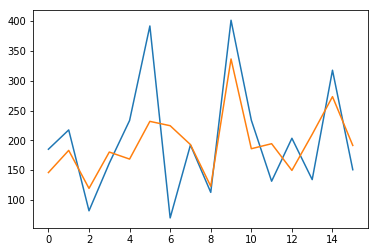

In [24]:
predictions = show_train_fit()
predictions = np.array(predictions)
predictions = predictions.reshape(predictions.shape[0], 1)

plt.plot(predictions) # blue line
plt.plot(origin_y_train[:predictions.shape[0]]) # yellow line
plt.show()

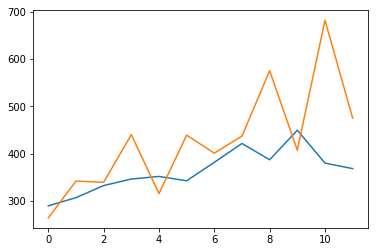

In [23]:
predictions = show_test_fit()
predictions = np.array(predictions)
predictions = predictions.reshape(predictions.shape[0], 1)

plt.plot(predictions) # blue line
plt.plot(origin_y_test[:predictions.shape[0]]) # yellow line
plt.show()